# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para Proyecto](#path)
- [3 - Análisis de Datos Exploratorios (EDA)](#eda)
- [4 - Data Augmentation](#aug)
- [5 - Metadata](#meta)
- [6 - Carga de imágenes y metadata](#carga)
- [7 - Creación de DataBlock](#db)
- [8 - Función de Accuracy: ATSIA_ACC](#acc_atsia)
- [9 - Función de Pérdida: Binary Cross-Entropy with Logits Loss](#loss_fun)
- [10 - Modelo](#model)
- [11 - Métricas](#metrics)
- [12 - Resutados](#results)
- [13 - Widget Prueba](#widget)

<a name='lib'></a>
## Librerías

In [3]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from utils_ATSIA import *

import os
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [4]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestino", "Uropodo"]
grados = ["G0", "G1", "G2", "G3", "G4"]
caracteristicas = {"AmpollaRectal" :["GG", "N"], #"Gregarinas Gametocistos, Nemátodos"
                   "Branquias" : ["S", "M", "N", "P", "AF"],# "Suciedad, Melanización, Necrosis, Protozoarios y Algas Filamentosas"
                   "Hepatopancreas" : ["DC", "DT", "L", "M", "N"], #"Deformidad Celular, Desprendimiento Tubular, Lípidos, Melanización y Necrosis"
                   "Intestino" : ["GT", "GG", "N", "A", "RC"], #"Gregarinas Trofozoito, Gregarina Gametocistos, Nemátodos, Algas y Restos de Crustaceos"
                   "Uropodo" : ["Prem", "Muda", "Post", "Inte"]}

#Necesitamos la cantidad de caracteres que cada nomenclatura tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 26, "Intestino" : 27, "Uropodo" :4}

In [5]:
main_path = Path(os.getcwd()) #Cuando estemos en local
Path.BASE_PATH = main_path
# main_path = "/content/drive/MyDrive/ATSIA" #Cuando usamos Google Drive
path = {}
path["data"] = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos: 
    if not os.path.exists(Path(os.path.join("data", organo))):
        os.mkdir(Path(os.path.join("data", organo)))
    if not os.path.exists(Path(os.path.join("img", organo))):
        os.mkdir(Path(os.path.join("img", organo)))
    if not os.path.exists(Path(os.path.join("metadata", organo))):
        os.mkdir(Path(os.path.join("metadata", organo)))

for organo in organos:
    path["data"][organo] = Path(os.path.join("data", organo, f"X_{organo}.npy"))
    path["img"][organo] = Path(os.path.join("img", organo))
    path["metadata"][organo] = Path(os.path.join("metadata", organo, f"metadata_{organo}.csv"))

<a name='eda'></a>
## Análisis Exploratorio de Datos (EDA)

In [6]:
count = get_img_count(organos, organo_len, caracteristicas, grados, path)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 125.30it/s]


No hay imágenes en la carpeta img/AmpollaRectal
No hay imágenes en la carpeta img/Branquias


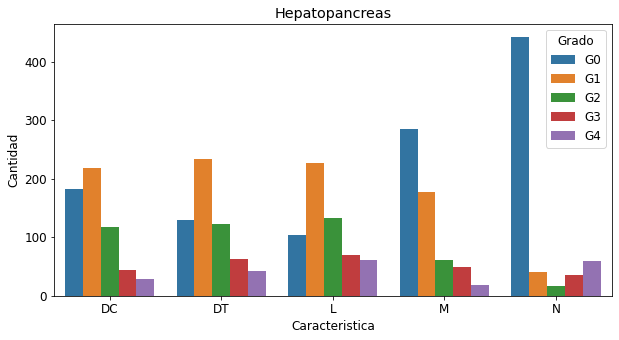

No hay imágenes en la carpeta img/Intestino
No hay imágenes en la carpeta img/Uropodo


In [7]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        hepato=data
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Caracteristica", y = "Cantidad", hue = "Grado")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")

No hay imágenes en la carpeta img/AmpollaRectal
No hay imágenes en la carpeta img/Branquias


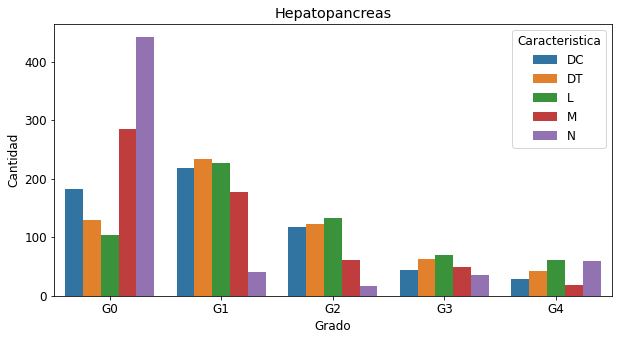

No hay imágenes en la carpeta img/Intestino
No hay imágenes en la carpeta img/Uropodo


In [8]:
for organo in organos: 
    data = count[count["Organo"] == organo]
    if data["Cantidad"].sum() != 0:
        plt.figure(figsize=(10,5))
        sns.barplot(data = data, x = "Grado", y = "Cantidad", hue = "Caracteristica")
        plt.title(f"{organo}", )
        plt.show()
    else:
        print(f"No hay imágenes en la carpeta {path['img'][organo]}")


<a name='model'></a> 
## Class weight for imbalanced datasets

In [9]:
# pos_weight= {}
# weight = {}
# for organo in organos:
#     total_img = len(get_image_files(path["img"][organo]))
#     pos_count = count[count["Organo"] == organo]["Cantidad"]
#     pos_weight[organo] = (total_img - pos_count)/pos_count
#     weight[organo] = (total_img)/pos_count

In [10]:
# pos_weight["Hepatopancreas"].values

In [11]:
# weight["Hepatopancreas"].values

<a name='meta'></a>
## Metada

In [12]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [13]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = path["metadata"][organo], index=False)
metadata

img_name                      labels
0         DT_G3-DC_G0-L_G4-M_G0-N_G0.png  DT_G3 DC_G0 L_G4 M_G0 N_G0
1     DT_G2-DC_G0-L_G2-M_G1-N_G1 (2).png  DT_G2 DC_G0 L_G2 M_G1 N_G1
2     DT_G4-DC_G2-L_G4-M_G3-N_G4 (7).png  DT_G4 DC_G2 L_G4 M_G3 N_G4
3     DT_G1-DC_G4-L_G2-M_G4-N_G1 (2).png  DT_G1 DC_G4 L_G2 M_G4 N_G1
4    DT_G1-DC_G0-L_G1-M_G0-N_G0 (13).png  DT_G1 DC_G0 L_G1 M_G0 N_G0
..                                   ...                         ...
587       DT_G0-DC_G1-L_G3-M_G0-N_G2.png  DT_G0 DC_G1 L_G3 M_G0 N_G2
588   DT_G0-DC_G0-L_G1-M_G0-N_G0 (9).png  DT_G0 DC_G0 L_G1 M_G0 N_G0
589       DT_G2-DC_G1-L_G3-M_G2-N_G3.png  DT_G2 DC_G1 L_G3 M_G2 N_G3
590   DT_G1-DC_G2-L_G1-M_G2-N_G0 (2).png  DT_G1 DC_G2 L_G1 M_G2 N_G0
591       DT_G3-DC_G1-L_G1-M_G1-N_G0.png  DT_G3 DC_G1 L_G1 M_G1 N_G0

[592 rows x 2 columns]

<a name='carga'></a> 
## Carga de imágenes y metadata 

In [14]:
metadata_csv = pd.read_csv(path["metadata"][organo], sep = ",")
metadata_csv.sample(3)

img_name                      labels
499  DT_G2-DC_G1-L_G2-M_G0-N_G1.png  DT_G2 DC_G1 L_G2 M_G0 N_G1
587  DT_G0-DC_G1-L_G3-M_G0-N_G2.png  DT_G0 DC_G1 L_G3 M_G0 N_G2
195  DT_G1-DC_G0-L_G3-M_G0-N_G0.png  DT_G1 DC_G0 L_G3 M_G0 N_G0

<a name='aug'></a> 
## Data Augmentation

In [15]:
img = PILImage(PILImage.create("TEST_IMAGE.png").resize((600,400)))
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

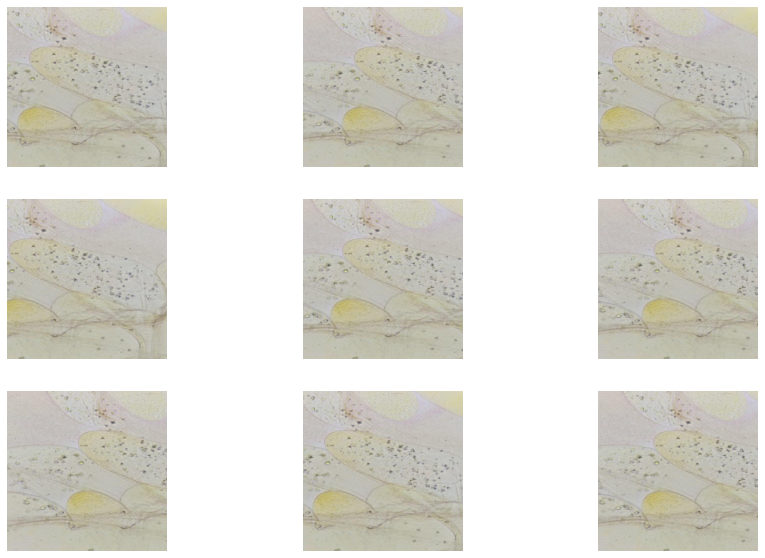

In [16]:
_,axs = plt.subplots(3,3, figsize=(15,10))
for ax in axs.flatten():
#     show_image(RandomResizedCrop(500, min_scale = 0.8, max_scale = 1)(img, split_idx=0), ctx=ax)
    show_image(Resize(500,method='crop', pad_mode='zeros')(img, split_idx=0), ctx=ax)

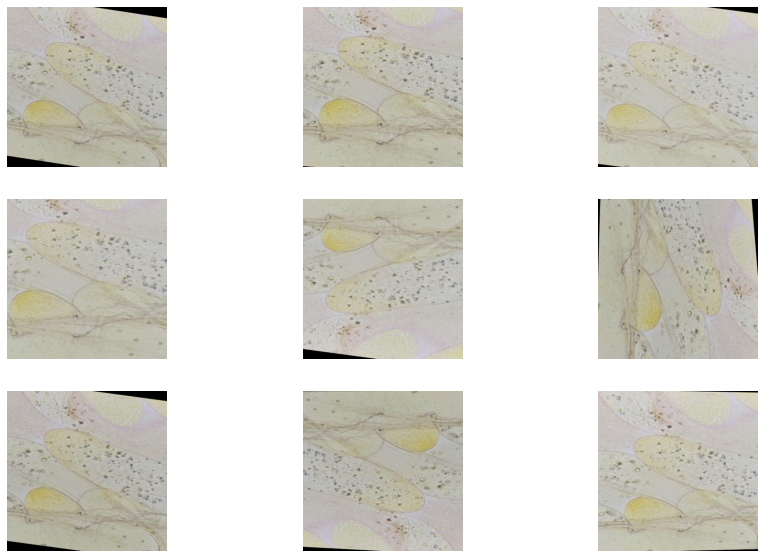

In [17]:
tfms = aug_transforms(mult=1.0, 
                      do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10.0, 
                      min_zoom=1.0, 
                      max_zoom=1.2, 
                      max_lighting=0.1, 
                      max_warp=0.1, 
                      p_affine=0.75, 
                      p_lighting=0.75, 
                      xtra_tfms=None, 
                      mode='bilinear', 
                      pad_mode='zeros', 
                      align_corners=True, 
                      batch=False, 
                      min_scale=0.75)
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(3,3, figsize=(15,10))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

<a name='db'></a> 
## Creación de DataBlock

In [18]:
def get_x(r): return Path(path["img"][organo], r['img_name'])
def get_y(r): return r['labels'].split(" ")
     
    
def get_data(presize, resize):
    return DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     get_x = get_x, 
                     get_y = get_y, 
                     item_tfms = Resize(presize, method='crop', pad_mode='zeros'), # RatioResize(500)
                     splitter = RandomSplitter(valid_pct=0.2, seed=42),
                     batch_tfms =[*aug_transforms(size = resize,
                                                  mult=1.0,
                                                  do_flip=True,
                                                  flip_vert=True,
                                                  max_rotate=10.0, 
                                                  min_zoom=1.0, 
                                                  max_zoom=1.2,   
                                                  mode='bilinear', 
                                                  pad_mode='zeros',  
                                                  min_scale=0.75),Normalize.from_stats(*imagenet_stats)]
                    )

In [19]:
dblock = get_data(500, 250)

### Creación del Dataset

In [20]:
dsets = dblock.datasets(metadata_csv)
dsets.train[0]

(PILImage mode=RGB size=2040x1528,
 TensorMultiCategory([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [21]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#5) ['DC_G1','DT_G1','L_G2','M_G1','N_G0']

### Creación del datablock

### Con batchsize = 16

In [22]:
# dblock = get_data(500, 250)
dls = dblock.dataloaders(metadata, bs=16)

In [23]:
print(len(dls.vocab))
labels = dls.vocab
print(labels)

25
['DC_G0', 'DC_G1', 'DC_G2', 'DC_G3', 'DC_G4', 'DT_G0', 'DT_G1', 'DT_G2', 'DT_G3', 'DT_G4', 'L_G0', 'L_G1', 'L_G2', 'L_G3', 'L_G4', 'M_G0', 'M_G1', 'M_G2', 'M_G3', 'M_G4', 'N_G0', 'N_G1', 'N_G2', 'N_G3', 'N_G4']


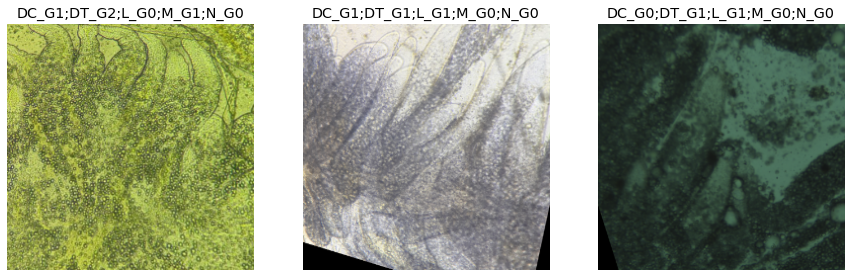

In [24]:
dls.show_batch(nrows=1, ncols=3, figsize=(15,10))

<a name='acc_atsia'></a> 
## Función de Accuracy: ATSIA_ACC

In [25]:
def get_info():
    return organo, caracteristicas, grados

def accuracy_multi_atsia(y_preds, y):
    y_preds = y_preds.sigmoid()    
    
    organo, caracteristicas, grados = get_info()
    columns =[]
    for caracteristica in caracteristicas[organo]:
        columns.append(f"ACC_{caracteristica}")
    #Al final columns vendrá en la forma columns = ["ACC_DC", "ACC_DT", "ACC_L", "ACC_M", "ACC_N"] para Hepatopancreas

    acc = pd.DataFrame(np.zeros((len(y_preds), len(columns))), columns = columns)

    for i in range(0, len(y_preds)):
        for j, caracteristica in enumerate(caracteristicas[organo]): 
            if j != len(grados)-1:
                preds = y_preds[i][len(grados)*j : len(grados)*(j+1)]
                targs = y[i][len(grados)*j : len(grados)*(j+1)]

            else:
                preds = y_preds[i][len(grados)*j :]
                targs = y[i][len(grados)*j :]

            if torch.eq(preds.argmax(), targs.argmax()):
                acc[f"ACC_{caracteristica}"][i] = 1
                
    #print(len(y_preds), acc.describe().loc["mean"].mean())
    return acc.describe().loc["mean"].mean()

<a name='loss_fun'></a> 
## Función de Pérdida: Binary Cross-Entropy with Logits Loss

In [26]:
class BCEWithLogitsLossFlat_atsia(BaseLoss):
    '''FOR USE OF ATSIA: Same as `nn.BCEWithLogitsLoss`, but flattens input and target.
    * Se modificó la función __init__ para que tenga en consideración las caracteristicas y el 
      organo que se está evaluando.
    *  Se modificó la función decodes para satisfacer las necesidades del proyecto de siempre
      predicir 1 etiqueta (grado) para cada característica, es decir, debe de predecir 
      len(caracteristica[organo]) etiquetas
    '''
    
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, organo, caracteristicas, grados,  **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh
        self.organo = organo
        self.caracteristicas = caracteristicas
        self.grados = grados        
    
    def decodes(self, x):     
        '''Usado para poder obtener los valores más altos de cada caracteristica como 1 y el resto como
        0 para cuando toque hacer el ploteo de learn.show_results(). Entra un tensor con 
        shape = len(caractetisticas[organo] * len(grados) con los valores luego de haber pasado por la 
        sigmoid, se escoge el mayor en intervalos de 5 en 5, dandole el valor de 1 y el resto 0. 
        Ej:
        preds = [0.1, 0.2, 0.3, 0.4, 0.5,         preds_norm = [0, 0, 0, 0, 1,
                 0.6, 0.9, 0.7, 0.1, 0.2]                       0, 1, 0, 0, 0]
        y luego preds_norm se comparará con el ground truth cuando se utilice el método show_results
        de la librería fast.ai'''
        
        preds_norm = np.array(np.zeros(x.shape))   
        for i in range(0, len(x)):
            cat = []
            for j, caracteristica in enumerate(self.caracteristicas[self.organo]): 
                if j != len(self.grados)-1:
                    temp = x[i][len(self.grados)*j : len(self.grados)*(j+1)]
                else:
                    temp = x[i][len(self.grados)*j :]
                    
                temp_new = np.zeros(len(temp))
                temp_new[temp.argmax()] = 1
                cat = np.append(cat, temp_new)
            preds_norm[i] = np.array(cat)

        preds_norm = torch.from_numpy(preds_norm)       
        return preds_norm>self.thresh
    
    def activation(self, x): return torch.sigmoid(x)

<a name='model'></a> 
## Modelo

In [27]:
learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = accuracy_multi_atsia,
                    loss_func = BCEWithLogitsLossFlat_atsia(organo = organo, 
                                                            caracteristicas = caracteristicas, 
                                                            grados = grados
                                                           )
                   )

SuggestedLRs(valley=0.002511886414140463)

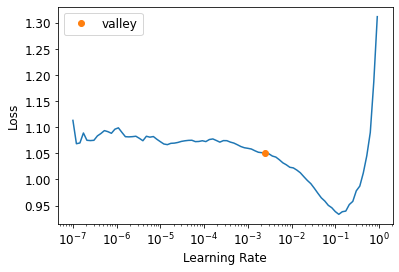

In [31]:
learn.lr_find()

In [34]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(35, lr_max = slice(1e-3, 5e-2), cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.5457627118644068.
Better model found at epoch 1 with accuracy_multi_atsia value: 0.5694915254237288.
Better model found at epoch 2 with accuracy_multi_atsia value: 0.576271186440678.
Better model found at epoch 33 with accuracy_multi_atsia value: 0.5813559322033897.


SuggestedLRs(valley=0.0010000000474974513)

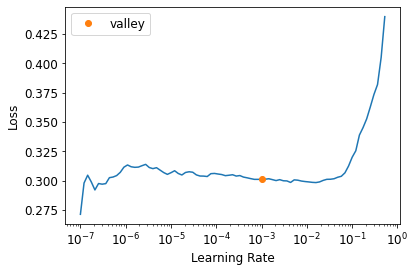

In [33]:
learn.lr_find()

In [37]:
learn.unfreeze()

In [38]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(35, lr_max = slice(1e-8, 5e-6), cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.5644067796610169.
Better model found at epoch 1 with accuracy_multi_atsia value: 0.5661016949152542.
Better model found at epoch 2 with accuracy_multi_atsia value: 0.5694915254237288.
Better model found at epoch 29 with accuracy_multi_atsia value: 0.5728813559322034.


SuggestedLRs(valley=0.00019054606673307717)

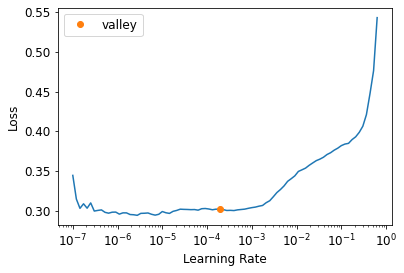

In [36]:
learn.lr_find()

In [39]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]

learn.fine_tune(70, base_lr=1e-6, freeze_epochs = 20, cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.6135593220338982.
Better model found at epoch 3 with accuracy_multi_atsia value: 0.6169491525423728.
Better model found at epoch 10 with accuracy_multi_atsia value: 0.6220338983050847.


Better model found at epoch 0 with accuracy_multi_atsia value: 0.6135593220338984.
Better model found at epoch 5 with accuracy_multi_atsia value: 0.6203389830508474.
Better model found at epoch 13 with accuracy_multi_atsia value: 0.6220338983050847.
Better model found at epoch 36 with accuracy_multi_atsia value: 0.6220338983050848.
Better model found at epoch 52 with accuracy_multi_atsia value: 0.6254237288135595.


In [68]:
dblock = get_data(750, 500)
dls = dblock.dataloaders(metadata, bs=16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = accuracy_multi_atsia,
                    loss_func = BCEWithLogitsLossFlat_atsia(organo = organo, 
                                                            caracteristicas = caracteristicas, 
                                                            grados = grados
                                                           )
                   )

SuggestedLRs(valley=0.0020892962347716093)

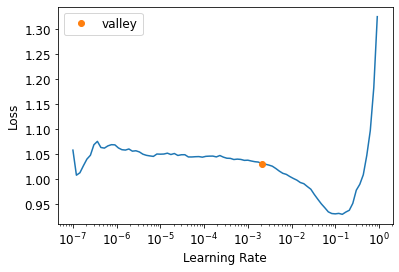

In [44]:
learn.lr_find()

In [ ]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(35, lr_max = slice(1e-3, 5e-2), cbs = cbs)

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()

In [ ]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]
learn.fit_one_cycle(35, lr_max = slice(1e-8, 5e-6), cbs = cbs)

In [ ]:
learn.lr_find()

In [45]:
cbs = [SaveModelCallback(monitor= 'accuracy_multi_atsia', fname = 'model_test'),
      MixUp()]

learn.fine_tune(70, base_lr=5e-3, freeze_epochs = 20, cbs = cbs)

Better model found at epoch 0 with accuracy_multi_atsia value: 0.3372881355932203.
Better model found at epoch 1 with accuracy_multi_atsia value: 0.4288135593220339.
Better model found at epoch 2 with accuracy_multi_atsia value: 0.44745762711864406.
Better model found at epoch 3 with accuracy_multi_atsia value: 0.5016949152542373.
Better model found at epoch 6 with accuracy_multi_atsia value: 0.5559322033898305.
Better model found at epoch 9 with accuracy_multi_atsia value: 0.576271186440678.
Better model found at epoch 10 with accuracy_multi_atsia value: 0.5881355932203389.
Better model found at epoch 13 with accuracy_multi_atsia value: 0.588135593220339.
Better model found at epoch 16 with accuracy_multi_atsia value: 0.6050847457627119.


Better model found at epoch 0 with accuracy_multi_atsia value: 0.5898305084745762.
Better model found at epoch 4 with accuracy_multi_atsia value: 0.5949152542372882.
Better model found at epoch 21 with accuracy_multi_atsia value: 0.6016949152542372.
Better model found at epoch 62 with accuracy_multi_atsia value: 0.6067796610169491.


<a name='metrics'></a> 
## Métricas

In [ ]:
dblock = get_data(750, 500)
dls = dblock.dataloaders(metadata, bs=16)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics = accuracy_multi_atsia,
                    loss_func = BCEWithLogitsLossFlat_atsia(organo = organo, 
                                                            caracteristicas = caracteristicas, 
                                                            grados = grados
                                                           )
                   )

In [35]:
learn.load("model_test")

In [36]:
learn.metrics = accuracy_multi_atsia
learn.validate()

(#2) [1.07192063331604,0.5813559322033897]

In [ ]:
learn.model = learn.model.cpu()
learn.export()

In [73]:
preds,targs = learn.get_preds()

In [74]:
preds[0]

TensorBase([8.2310e-01, 7.6271e-02, 2.2109e-02, 3.7024e-04, 6.4936e-03, 1.9889e-01, 5.1002e-01, 2.0267e-02, 3.7222e-03, 3.6318e-04, 7.5748e-01, 6.6143e-01, 2.3002e-02, 1.0273e-03, 4.5549e-03, 9.9369e-01,
        2.1190e-02, 1.1328e-03, 2.1979e-03, 3.6800e-04, 9.9733e-01, 6.3012e-04, 6.1244e-04, 9.9393e-04, 3.5374e-04])

In [75]:
targs[0]

TensorMultiCategory([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [77]:
def get_preds_norm(x):
    preds_norm = np.array(np.zeros(x.shape))
    for i in range(0, len(x)):
        cat = []
        for j, caracteristica in enumerate(caracteristicas[organo]): 
            if j != len(grados)-1:
                temp = x[i][len(grados)*j : len(grados)*(j+1)]
            else:
                temp = x[i][len(grados)*j :]

            temp_new = np.zeros(len(temp))
            temp_new[temp.argmax()] = 1
            cat = np.append(cat, temp_new)
        preds_norm[i] = np.array(cat)

    preds_norm = torch.from_numpy(preds_norm)
    
    return preds_norm

In [78]:
from sklearn.metrics import multilabel_confusion_matrix
predsnorm = get_preds_norm(preds)
vis_arr = multilabel_confusion_matrix(targs, predsnorm)

In [79]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CFM - " + class_label)

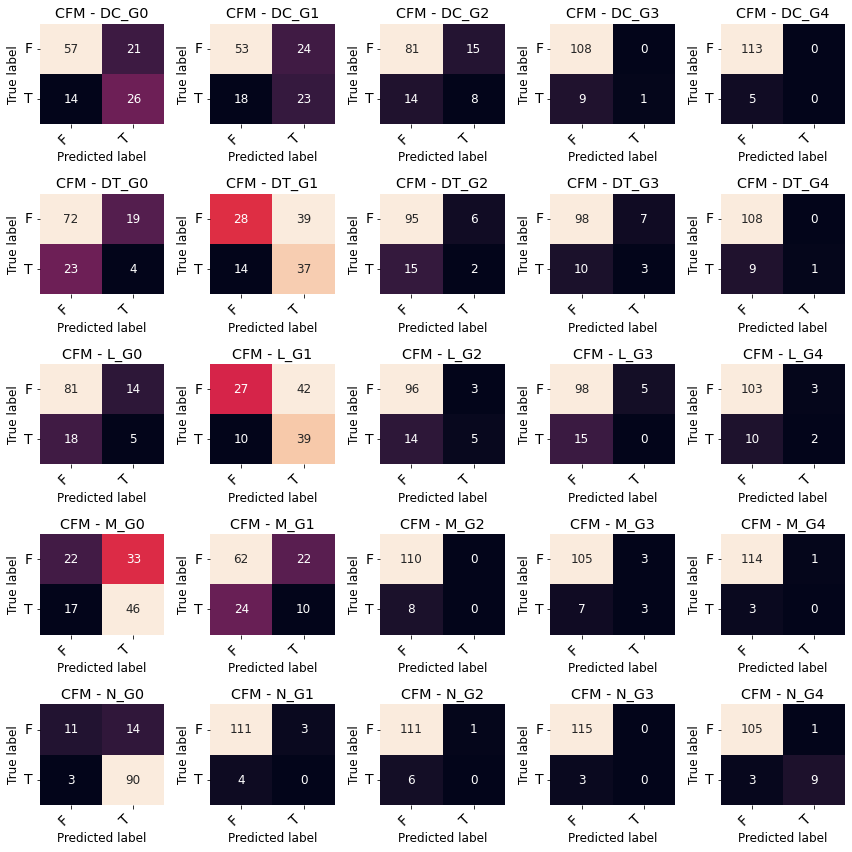

In [81]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["F", "T"])

fig.tight_layout()
plt.show()

<a name='results'></a> 
## Resultados

In [84]:
learn.load(Path("model_test_06169_resize_750_size_500_mixup"))

In [85]:
learn.metrics = accuracy_multi_atsia
learn.validate()

(#2) [0.33398300409317017,0.6169491525423728]

In [ ]:
# learn.export()

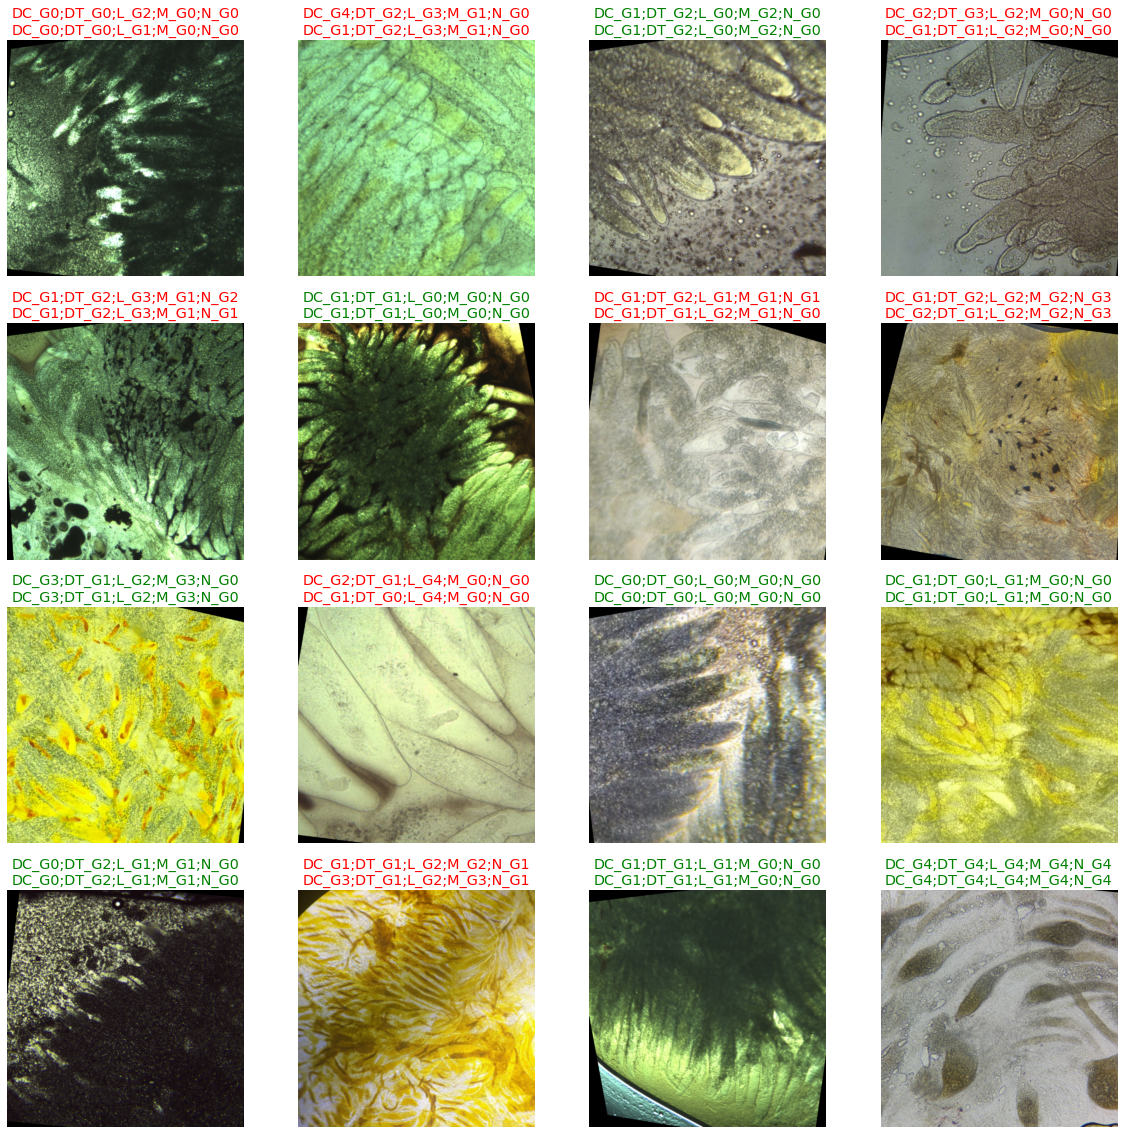

In [86]:
learn.show_results(dl = dls.train, ds_idx = 0, max_n = 16, figsize = (20,20), shuffle=False)

<a name='widget'></a> 
## Widget Test

In [46]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [47]:
img = PILImage.create(btn_upload.data[-1])

In [48]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(500,500))
out_pl

Output()

In [49]:
pred,pred_idx,probs = learn.predict(img)
pred

(#5) ['DC_G1','DT_G2','L_G2','M_G0','N_G0']

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression